# First `politician2vec` demo

## To do
- ~~Descriptive statistics/viz for entire dataset~~
- ~~Settle on centroid calculation method (handle outliers better, remove alt method?)~~
- ~~POC visualisations and projections of parliamentary dimensions~~
- Final visualisations and projections for all three venues
    - Abstract this into functions
- Compile populism-related words for constructing axes
- Consistently change "topic" to "party"/"cluster" or the like

In [1]:
%pip uninstall politician2vec -y

Found existing installation: politician2vec 0.0.1
Uninstalling politician2vec-0.0.1:
  Successfully uninstalled politician2vec-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

  Cloning ssh://****@github.com/mathiasbruun/politician2vec.git to /private/var/folders/8q/02vc3fzn3r1fv7wzycyspjz80000gn/T/pip-req-build-7_1xy0e5
  Running command git clone -q 'ssh://****@github.com/mathiasbruun/politician2vec.git' /private/var/folders/8q/02vc3fzn3r1fv7wzycyspjz80000gn/T/pip-req-build-7_1xy0e5
  Created wheel for politician2vec: filename=politician2vec-0.0.1-py3-none-any.whl size=27418 sha256=54eca48890b4bf060429ce14c88f06e1c5172f1c5298f82fef97eb3503aa62e5
  Stored in directory: /private/var/folders/8q/02vc3fzn3r1fv7wzycyspjz80000gn/T/pip-ephem-wheel-cache-64_l8cex/wheels/ac/44/62/b0b3ddf2882cd1b1d1cc4e060c5c525b951ae01496d65cd472
Successfully built politician2vec
Note: you may need to restart the kernel to use updated packages.


In [195]:
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
import multiprocessing
available_workers = multiprocessing.cpu_count()
import matplotlib.pyplot as plt

In [4]:
test_data_path = 'data/clean/combined/subset_party_imputed_v2.p'

In [5]:
with open(test_data_path, 'rb') as p:
    test_data = pickle.load(p)

test_data.shape

(349594, 7)

In [175]:
# parl_data = test_data.loc[
#     (test_data['source'] == 'parliament') &
#     ~(test_data['party'].isin(['SIU', 'NQ', 'JF', 'SP']))
# ]
#
# tw_data = test_data.loc[
#     test_data['source'] == 'twitter'
# ]
#
meta_data = test_data.loc[
    (test_data['source'] == 'meta') &
    test_data['doc'].notna()
]

In [7]:
meta_data['party'].value_counts(dropna = False)

V      7182
SF     4900
S      3465
LA     3424
KF     2825
DF     2059
NB     1909
RV     1565
EL      823
FG      689
ALT     175
DD       76
M        28
KD       18
SIU       9
UFG       5
Name: party, dtype: int64

In [176]:
grouped_docs = meta_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()

In [177]:
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])

In [10]:
ngram_options = {
    'min_count': 5,
    'threshold': 1,
    'delimiter': ' '
}

In [12]:
pol2vec_model = Politician2Vec(
    documents = docs,
    custom_clusters = parties,
    party_inference_method = 'mean',
    tokenizer = preproc_docs,
    embedding_model = 'doc2vec',
    min_count = 50,
    ngram_vocab = True,
    ngram_vocab_args = ngram_options,
    speed = 'fast-learn', # CHANGE FOR REAL RUNS
    workers = available_workers
    #doc2vec_vector_size = 300,
    #doc2vec_window = 8,
    #doc2vec_samples_threshold = 1e-5
)

2022-11-26 17:03:09,568 - politician2vec - INFO - Pre-processing documents for training
2022-11-26 17:03:27,115 - politician2vec - INFO - Creating joint document/word embedding
2022-11-26 17:06:44,001 - politician2vec - INFO - Estimating party positions using mean...
2022-11-26 17:06:44,263 - politician2vec - INFO - All done!


In [15]:
# TODO: This should probably be implemented as a method of the Politician2Vec class
#
# NOTE: As of 2022-11-26, it has been decided to keep party 'inference' parallel to the original top2vec implementation.
#       This funtionality may prove useful in outlier detection, but--importantly--it requires the ex ante known party affilaitions
#       to be mapped to model output ex post instead of relying on inferred parties. Specifically, the 'estimated' party affiliations
#       may vary from ground truth labels in the case of semantically outlying politicians with only few data points.

def inspect_topic(politician2vec_model, topic_idx, n_docs=None, query_substr=None):
    '''
    Print top words and top docs for a given
    topic.
    -------
    manual_num (int):  automatically assigned topic number (i.e. 0-indexed).
    
    n_docs (int, optional): n top documents to print for a given topic.
        Default is to print all docs within a given topic.
    
    query_substr (str, optional): if specified, only documents containing
        this substring will be printed. Cannot be specified with n_docs,
        as this would return only results within a subset of topic docs.
    '''

    num_topics = politician2vec_model.get_num_topics()
    topic_words, word_scores, topic_nums = politician2vec_model.get_topics(num_topics)

    # Get topic sizes so we know max n docs
    topic_sizes, topic_nums = politician2vec_model.get_topic_sizes()
    docs_to_return = topic_sizes[topic_idx]

    # Override n docs to return, if specified
    if n_docs:
        docs_to_return = n_docs

    # Get docs for input topic id
    documents, document_scores, document_ids = politician2vec_model.search_documents_by_topic(
        topic_num=topic_idx,
        num_docs=docs_to_return
        )

    # Limit output to docs containign certain substring, if specified
    if query_substr and n_docs:
        raise Exception('Please do NOT specify n_docs with substring query!\nOtherwise the search is only carried out for a subset of topic docs.')
    
    # Throw exception if substring query attempted on subset of docs!
    elif query_substr:
        documents = [doc for doc in documents if query_substr in doc.lower()]

    # Print output
    print('--- TOP 50 WORDS ---\n', topic_words[topic_idx], '\n')

    print(f'--- TOP {docs_to_return} DOCS. SUBSTRING QUERY: {query_substr} (n = {len(documents)}) ---\n', documents)

In [13]:
word_vectors = pol2vec_model.model.wv
word_vectors.most_similar(positive = ['borgerlige'], topn = 25)

[('seier', 0.5158143639564514),
 ('nye', 0.5008494853973389),
 ('christensen', 0.443435400724411),
 ('peter', 0.4114103317260742),
 ('partier', 0.3841729760169983),
 ('udlændinge', 0.3797382414340973),
 ('borgerliges', 0.3787204325199127),
 ('politikerne', 0.3783581554889679),
 ('udvises', 0.36112114787101746),
 ('dom', 0.3538636863231659),
 ('asylstop', 0.35204508900642395),
 ('parti', 0.3434620797634125),
 ('politikernes', 0.341133177280426),
 ('plejer', 0.33092546463012695),
 ('islam', 0.3276260495185852),
 ('venstrefløjen', 0.32470881938934326),
 ('boje', 0.32467907667160034),
 ('danske', 0.321563184261322),
 ('mathiesen', 0.3173646330833435),
 ('kriminelle', 0.31686580181121826),
 ('forklarer', 0.31563183665275574),
 ('🦢', 0.3140852153301239),
 ('nedlægge', 0.3104330897331238),
 ('jobcentrene', 0.309643030166626),
 ('uacceptabelt', 0.3081356883049011)]

In [126]:
inspect_topic(pol2vec_model, 1, n_docs=1, query_substr=None)

--- TOP 50 WORDS ---
 ['sammen gode' '💙 håber' 'gode lokale' 'gode arbejdspladser'
 'sammen venstres' 'god påske' 'håber se' 'arbejdspladseri hele'
 'møde nye' 'store politiske' 'gerne 😊' 'skattehop venstre'
 'venstres forårsmøde' 'godt humør' 'venstres politiske' 'må arbejde'
 'se mere' 'politik synes' 'venstre garant' 'gode ældreliv' 'politik går'
 'venstre håber' 'ved valget' 'politiske arbejde' 'venstres politik'
 'politik indefra' 'glæder helt' 'kom regering'
 'venstres folketingsgruppe' 'aften 😊' 'politiske sæson'
 'politiske administrative' 'godt valg' 'bla gode' 'lokale kandidater'
 'bedre sammen' 'venstre dag' 'gang valgkampen' 'mindet kæmpe'
 'gode folkelige' 'siden finansminister' 'ved siden'
 'vejen christiansborg' 'lidt klem' '😊 god' 'venstre danmarks' 'gang lige'
 'kom folketinget' '💙 bor' 'sammen andre'] 

--- TOP 1 DOCS. SUBSTRING QUERY: None (n = 1) ---
 ['Søren Gade er folketingskandidat for Venstre i Midt- og Vestjylland.Søren Gade er folketingskandidat for Venstre i

In [179]:
model_path = 'embedding_models/politician2vec_test_meta_v1.txt'

In [20]:
pol2vec_model.save(model_path)

_____

## Viz dev

In [180]:
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [70]:
n_words = len(doc2vec_model.wv)
n_docs = len(doc2vec_model.dv)
vocab = pol2vec_model.vocab

In [417]:
## TWITTER DEEPLEARN
#topic_labels = {
#    0: 'Venstre',
#    1: 'Socialdemokratiet',
#    2: 'Dansk_Folkeparti',
#    3: 'Enhedslisten',
#    4: 'Radikale_Venstre',
#    5: 'SF',
#    6: 'Konservative',
#    7: 'Liberal_Alliance',
#    8: 'Alternativet',
#    9: 'Nye_Borgerlige',
#    10: 'Frie_Grønne',
#    11: 'Kristendemokraterne',
#    12: 'Moderaterne'
#}

In [419]:
## PARLIAMENT FASTLEARN
#topic_labels = {
#    0: 'Socialdemokratiet',
#    1: 'Venstre',
#    2: 'Dansk_Folkeparti',
#    3: 'Enhedslisten',
#    4: 'Radikale Venstre',
#    5: 'SF',
#    6: 'Konservative',
#    7: 'Liberal_Alliance',
#    8: 'UFG',
#    9: 'Alternativet',
#    10: 'Danmarksdemokraterne',
#    11: 'Nye Borgerlige',
#    12: 'Frie Grønne',
#    13: 'Moderaterne',
#    14: 'Kristendemokraterne'
#}

In [127]:
# META FASTLEARN
topic_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'SF',
   4: 'Enhedslisten',
   5: 'Radikale_Venstre',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'Alternativet',
   9: 'Danmarksdemokraterne',
   10: 'Nye_Borgerlige',
   11: 'UFG',
   12: 'Frie_Grønne',
   13: 'Kristendemokraterne',
   14: 'Grønlandsk',
   15: 'Moderaterne'
}

In [181]:
topic_df = get_doc_topic_df(
    pol2vec_model,
    no_substantive_topics = 16,
    snippets = True
)

Topic sizes before filtering (topic 16 is "Other"):

[[ 0 43]
 [ 1 40]
 [ 2 22]
 [ 3 16]
 [ 4 15]
 [ 5 14]
 [ 6 14]
 [ 7 10]
 [ 8  6]
 [ 9  5]
 [10  5]
 [11  4]
 [12  3]
 [13  2]
 [14  1]
 [15  1]]


In [158]:
import umap
import umap.plot
umap.plot.output_notebook(hide_banner=True)

In [159]:
colormap = {
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [182]:
topic_df['party'] = parties
topic_df['color'] = topic_df['party'].map(colormap)
cmap = topic_df[['snippet', 'color']].set_index('snippet').to_dict()
topic_df['full_name'] = grouped_docs['full_name']

In [183]:
topic_df.head()

,doc,top,snippet,party,color,full_name
0,0,14,✨Sapiillutit inuiaqatigiinni peqataasarit.✨ M...,SIU,lightgrey,Aki-Matilda Høegh-Dam
1,1,7,Røde Alex har kun hånlig latter til overs for ...,LA,#E7B657,Alex Vanopslagh
2,2,8,Til tonerne af jazz og smagen af lækker cider ...,ALT,#75FB4C,Alternativet
3,3,0,Udvikling til hjemstavnen. Vestjylland skal ig...,S,#C8042C,Anders Kronborg
4,4,5,Hvor dum og uretfærdig kan vores udlændingelov...,RV,#D82E8A,Andreas Steenberg


In [184]:
partyvecs = pol2vec_model.topic_vectors
partylabels = pd.DataFrame(topic_labels.values(), columns = ['party'])

In [185]:
combined_hover = pd.concat([topic_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

In [224]:
mapper = umap.UMAP(
    n_neighbors=15,
    metric='cosine',
    n_components=3
    ).fit(
        np.vstack([
            pol2vec_model.document_vectors,
            pol2vec_model.topic_vectors
            ]))

In [149]:
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )
umap.plot.show(p)

In [219]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

In [271]:
pca = PCA(n_components=1)

In [272]:
reduced = pca.fit_transform(
    np.vstack([
        pol2vec_model.document_vectors,
        pol2vec_model.topic_vectors
        ]))

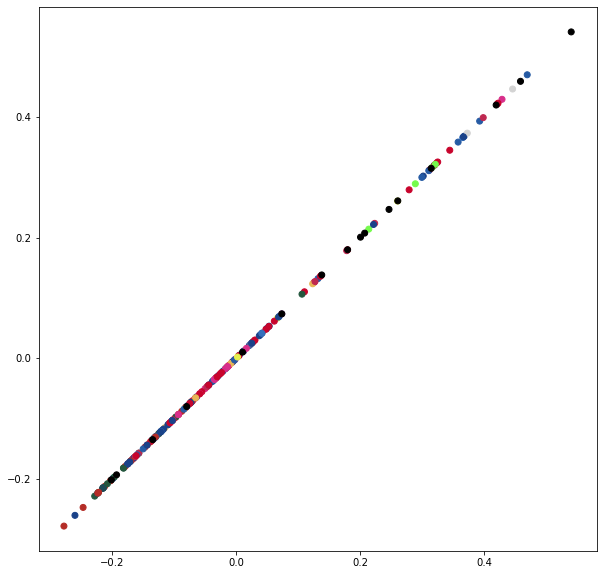

In [273]:
fig = plt.figure(figsize=(10,10))

ax = plt.scatter(
    x = reduced,
    y = reduced,
    c=combined_hover['color'],
    cmap=combined_hover['color']
    )

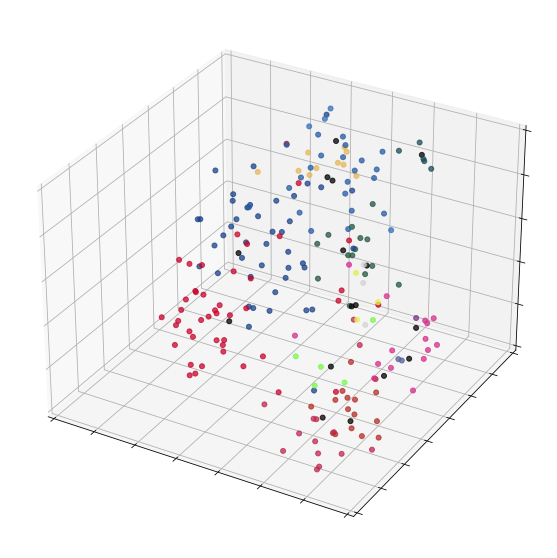

In [269]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

ax.set_xlim(2.5,6)
ax.set_ylim(4,7.5)
ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.text(x=x coordinate, y=y coordinate, s=string to be displayed)

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 25
    );

____

## TensorBoard exports

In [ ]:
doc2vec2tensor(
    doc2vec_model,
    temp_w2v_path = 'tensorboard_input/temp/doc_tensor_meta.w2v',
    tsv_prefix = 'tensorboard_input/meta',
    output_docvecs = True,
    output_wordvecs = False
)

In [79]:
metadata2tensor(
    topic_df,
    metadata_path = 'tensorboard_input/meta_metadata.tsv',
    label_list = topic_labels
)

In [80]:
# test read of tensor output
with open('tensorboard_input/meta_tensor.tsv','r') as r:
    lines_test = r.readlines()

len(lines_test)

194

In [81]:
def partyvecs2tensor(party_vecs, out_path):
    vec_strs = []

    for vec in party_vecs:
        vec_str = ''.join([str(val) +'\t' for val in vec]).rstrip('\t')
        vec_strs.append(vec_str)

    tensor_str = '\n'.join(vec_strs)
    
    with open(out_path, 'w') as f:
        f.write(tensor_str)

In [82]:
def concat_tensors(tensor_files, out_path):
    tensor_strs = []
    
    for file in tensor_files:
        tensor_str = pd.read_csv(file, sep = '\t', header = None)
        tensor_strs.append(tensor_str)
    
    concat_tensor = pd.concat(tensor_strs)
    
    concat_tensor.to_csv(out_path, sep = '\t', header = False, index = False)

In [83]:
partyvecs2tensor(
    party_vecs = pol2vec_model.topic_vectors,
    out_path = 'tensorboard_input/meta_parties.tsv'
)

In [84]:
label_df = pd.DataFrame(topic_labels, index = ['doc']).T
#label_df['topic'] = ''

In [85]:
label_df.to_csv(
    'tensorboard_input/meta_parties_metadata.tsv',
    sep = '\t',
    header = False,
    index = False
)

In [86]:
# Combine docvecs and partyvecs
politician_file = 'tensorboard_input/meta_tensor.tsv'
party_file = 'tensorboard_input/meta_parties.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined.tsv')

In [87]:
# Combine metadata
politician_file = 'tensorboard_input/meta_metadata.tsv'
party_file = 'tensorboard_input/meta_parties_metadata.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined_metadata.tsv')